<Body>   
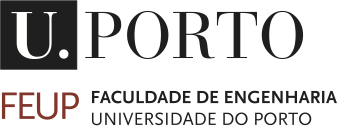   
<h1> <b>Swarm Robotics Competitions 2023/2024 </b> </h1>
</Body>  

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt)

**José Pedro Carvalho** (jose.carvalho@fe.up.pt)

FEUP, Oct. 2023

---


# **Identification**

**Group:** xx

* **Name:** xxx **Student Number:** xx
* **Name:** xxx **Student Number:** xx
* **Name:** xxx **Student Number:** xx
* **Name:** xxx **Student Number:** xx
* **Name:** xxx **Student Number:** xx


---





# Swarm Marathon Competition


**Goal:** Collect a set of resources at positions $R_i$, $i=1, \ldots M$, and drop them at the warehouse (green border in the plot) within a fixed period of time $T$.

**Specifications:**
-  The fleet is composed by 5 drones.
- Drone 1 is the leader and has access to its global position $x_1=[x_{1_1} x_{2_1}]$.
-  All the other drones *only* have access to the relative position $x_{ij}$ with respect to the other drones, if they are close enough to them (maximum range of MAX_RANGE).  
Example: Suppose that drone 1 and 3 are the only ones that are close to drone 2, then
drone 2 has access to the relative position $x_{21}=x_2-x_1$ and $x_{23}=x_2-x_3$, while the others by convention take the value zero $x_{24}=x_{25}=0$.
- All drones have access to the closest distance and angle (direction) of the nearest obstacle, that is, $d_{io}$ and $\theta_{io}$.
- The maximum linear velocities (input) in $x$ and $y$ directions is $1\,m/s$, that is, $-1\le u_x, u_y \le 1$.
- The resources can only be picked and transported with two drones. Moreover, when two drones are carrying a resource, they cannot carry a second resource, and they should be no more than MAX_R_DIS apart of each other, otherwise it is considered that the resource is lost.
- The drones cannot collide with each other, walls, and obstacles. In case of collision, the drone that collided stop and you do not have access to it. If it was transporting a resource, the resource returns to its initial position.

**Scores:**
- The times of picking the resources and dropping in the warehouse are saved. If the drones lost the resource, the time will be reseted.

- Wins the one that returned the maximum number of resources at the warehouse in less time.

**Parameters of this scenario:**
- Range of communication to obtain the relative position: MAX_RANGE = $5\,m$
- Maximum distance between 2 drones that they can be to pick a resource: MAX_R_PICK = $1\,m$
- Maximum distance between 2 drones that they can be to transport a resource: MAX_R_DIS = $3\,m$
- Initial configuration of the drones: 5-4-1-2-3 with same position in $y=-8\,m$ and in $x$ of $-2\,m, -1\,m, 0\,m, 1\,m, 2\,m$, respectively.
---

**Initial setup:** To download the file **aux_file.py**, run the next cell (only once).

In [1]:
!git clone --depth 1 https://github.com/Jose-PCarvalho/CSR.git

Cloning into 'CSR'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 14), reused 1 (delta 1), pack-reused 0
Receiving objects: 100% (41/41), 1.81 MiB | 3.62 MiB/s, done.
Resolving deltas: 100% (14/14), done.




---
# **Scenario Task 3:** Two Resources $R_1$ and $R_2$ and two obstacles


You can include here the formulas used to compute $u_i$, $i=1, \ldots, 5$, that is
$$
u_1 = \ldots
$$

In [2]:
Gnumber = 0  #Group number
%load CSR/csr_lib.py
from CSR.csr_lib import *
import numpy as np
import yaml


In [33]:

def my_swarm_control_law(state_dict, angle, x):
    R1 = state_dict["Resource Position"][0]
    R2 = state_dict["Resource Position"][1]
    R1_caught = state_dict["Resource Caught"][0]
    R2_caught = state_dict["Resource Caught"][1]
    R1_at_warehouse = state_dict["Resource Delivered"][0]
    R2_at_warehouse = state_dict["Resource Delivered"][1]
    do = state_dict["Distance to Obstacle"]
    state1 = state_dict["Leader State"]

    x21, x23, x24, x25 = x[1][0], x[1][2], x[1, 3], x[1, 4]
    x31, x32, x34, x35 = x[2][0], x[2][1], x[2, 3], x[2, 4]
    x41, x42, x43, x45 = x[3][0], x[3][1], x[3, 2], x[3, 4]
    x51, x52, x53, x54 = x[4][0], x[4][1], x[4, 2], x[4, 3]

    # My parameters
    kx, ky = 1, 1
    K = np.diag([kx, ky])
    kx, ky = 1.5, 1.5
    K1 = np.diag([kx, ky])
    Ko_init = 1 * np.diag([1, 1])
    Kd_init = 2 * np.diag([1, 1])
    c = 5
    c1 = 2
    warehouse = {1: [-7.5, -7.5], 2: [-7.5, 7.5]}
    W1 = warehouse[1]

    # Control law
    if R1_caught == False and R1_at_warehouse == False:
        # print("I'm steering to R1")
        xd = (R1[0] - 1.5, R1[1])
        b12 = [-0.2, 0.0]
        b23 = [-0.2, 0.0]
        b14 = [0.2, 0.0]
        b45 = [0.2, 0.0]

    if R1_caught == True and R2_caught == False:
        # print("I'm steering to R2")

        xd = (R2[0], R2[1])
        b12 = [0.2, 0.0]
        b23 = [0.2, 0.0]
        b14 = [-0.2, 0.0]
        b45 = [-0.2, 0.0]
    if (R1_caught == True or R1_at_warehouse) and (R2_caught == True or R2_at_warehouse):
        xd = (W1[0], W1[1])
        b12 = [0.2, 0.0]
        b23 = [0.2, 0.0]
        b14 = [-0.2, 0.0]
        b45 = [-0.2, 0.0]

    # Drone 1 - Leader
    u_control1 = - K @ (state1 - xd) - (1 / (do[0] + .1)) * Ko_init * np.exp(-c * do[0] ** 2) @ (
        np.cos(angle[0]), np.sin(angle[0]))

    # Drone 2
    u_control2 = - K1 @ ((x21 + b12)) \
                 + 1 / (np.linalg.norm(x21) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x21) ** 2) @ x21 \
                 + 1 / (np.linalg.norm(x23) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x23) ** 2) @ x23 \
                 + 1 / (np.linalg.norm(x24) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x24) ** 2) @ x24 \
                 + 1 / (np.linalg.norm(x25) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x25) ** 2) @ x25 \
                 - 1 / (do[1] + .1) * Ko_init * np.exp(-c * do[1] ** 2) @ (np.cos(angle[1]), np.sin(angle[1]))

    # Drone 3
    # u_control3 = ...
    u_control3 = - K1 @ ((x32 + b23)) \
                 + 1 / (np.linalg.norm(x31) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x31) ** 2) @ x31 \
                 + 1 / (np.linalg.norm(x32) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x32) ** 2) @ x32 \
                 + 1 / (np.linalg.norm(x34) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x34) ** 2) @ x34 \
                 + 1 / (np.linalg.norm(x35) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x35) ** 2) @ x35 \
                 - 1 / (do[2] + .1) * Ko_init * np.exp(-c * do[2] ** 2) @ (np.cos(angle[2]), np.sin(angle[2]))

    # Drone 4
    # u_control4 = ...
    u_control4 = - K1 @ ((x41 + b14)) \
                 + 1 / (np.linalg.norm(x41) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x41) ** 2) @ x41 \
                 + 1 / (np.linalg.norm(x42) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x42) ** 2) @ x42 \
                 + 1 / (np.linalg.norm(x43) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x43) ** 2) @ x43 \
                 + 1 / (np.linalg.norm(x45) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x45) ** 2) @ x45 \
                 - 1 / (do[3] + .1) * Ko_init * np.exp(-c * do[3] ** 2) @ (np.cos(angle[3]), np.sin(angle[3]))

    # Drone 5
    # u_control5 = ...
    u_control5 = - K1 @ ((x54 + b45)) \
                 + 1 / (np.linalg.norm(x51) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x51) ** 2) @ x51 \
                 + 1 / (np.linalg.norm(x52) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x52) ** 2) @ x52 \
                 + 1 / (np.linalg.norm(x53) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x53) ** 2) @ x53 \
                 + 1 / (np.linalg.norm(x54) ** 2 + .1) * Kd_init * np.exp(-c1 * np.linalg.norm(x54) ** 2) @ x54 \
                 - 1 / (do[4] + .1) * Ko_init * np.exp(-c * do[4] ** 2) @ (np.cos(angle[4]), np.sin(angle[4]))

    return u_control1, u_control2, u_control3, u_control4, u_control5
###################################################################################################
##                                                                                               ##
##                              End of your code section, do not edit the next part              ##
##                                                                                               ##
###################################################################################################

In [34]:
with open('CSR/competition_validation/cfg/mission_easy.yaml', 'r') as file:
    cfg_data = yaml.safe_load(file)
sim = Simulation(cfg_data)

for i in range(0, sim.t_signal.shape[0] - 1):

    if sim.t_signal[i] % 5 == 0:
        print("Time: t =", sim.t_signal[i])

    xij, ang = sim.get_relative_positions()
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(sim.state_dict, ang, xij)
    u = [u_control1, u_control2, u_control3, u_control4, u_control5]
    sim.step(u)

Time: t = 0.0


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Time: t = 5.0
Time: t = 10.0
Time: t = 15.0
Drone 2 found the Resource  1  at time t= 15.44
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.46
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.48
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.5
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.52
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.540000000000001
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.56
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.58
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.6
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.620000000000001
But no other drone found the Resource  1 ...
Dr

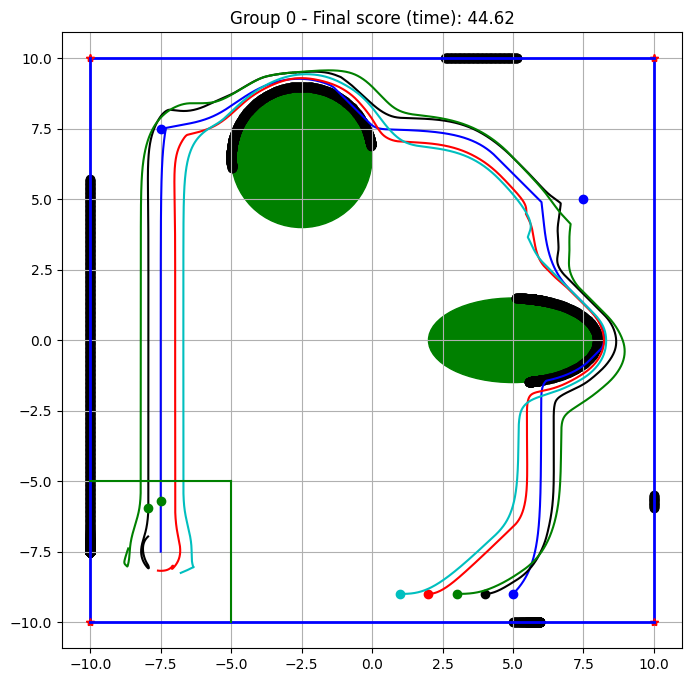

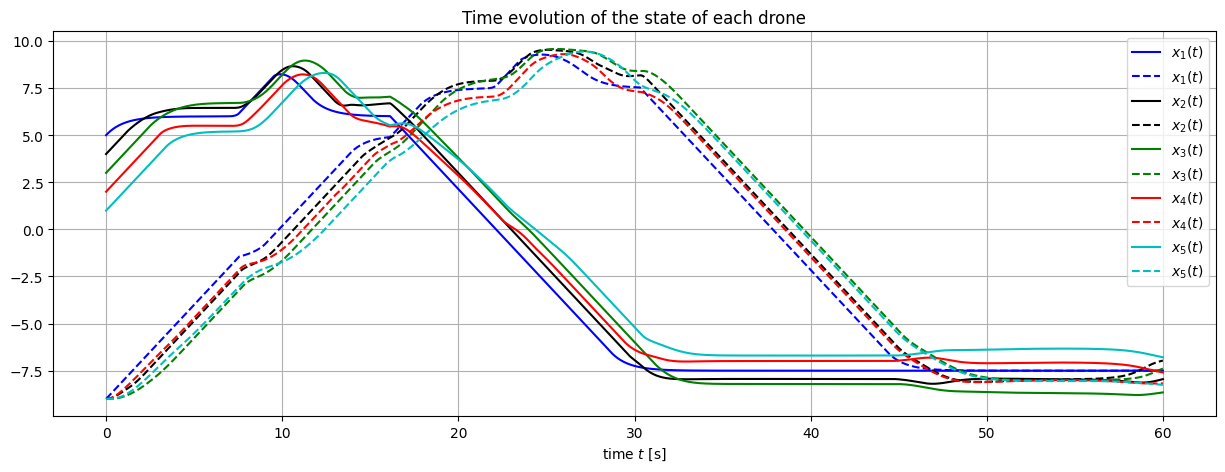

In [27]:
# Plot commands
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8, 8))

# plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim - 1, xdim + 1)
plt.ylim(-ydim - 1, ydim + 1)
plt.grid()

# Plots walls and obstacles
sim.world.plot()

pt1, = plt.plot([], [], 'b.', ms=20)
pt2, = plt.plot([], [], 'k.', ms=20)
pt3, = plt.plot([], [], 'g.', ms=20)
pt4, = plt.plot([], [], 'r.', ms=20)
pt5, = plt.plot([], [], 'c.', ms=20)
plt.plot(sim.x_signal[0, 0, 0], sim.x_signal[0, 1, 0], marker='o', color='b')
plt.plot(sim.x_signal[1, 0, 0], sim.x_signal[1, 1, 0], marker='o', color='k')
plt.plot(sim.x_signal[2, 0, 0], sim.x_signal[2, 1, 0], marker='o', color='g')
plt.plot(sim.x_signal[3, 0, 0], sim.x_signal[3, 1, 0], marker='o', color='r')
plt.plot(sim.x_signal[4, 0, 0], sim.x_signal[4, 1, 0], marker='o', color='c')

line1, = plt.plot(sim.x_signal[0, 0, :], sim.x_signal[0, 1, :], label='$x_1(t)$', color='b')
points_lidar = plt.scatter(sim.cpx[0], sim.cpy[0], label='$cpx_1(t)$', marker='o', color='k')
line2, = plt.plot(sim.x_signal[1, 0, :], sim.x_signal[1, 1, :], label='$x_2(t)$', color='k')
line3, = plt.plot(sim.x_signal[2, 0, :], sim.x_signal[2, 1, :], label='$x_3(t)$', color='g')
line4, = plt.plot(sim.x_signal[3, 0, :], sim.x_signal[3, 1, :], label='$x_4(t)$', color='r')
line5, = plt.plot(sim.x_signal[4, 0, :], sim.x_signal[4, 1, :], label='$x_5(t)$', color='c')
plt.plot((-10, -5), (-5, -5), color='g')
plt.plot((-5, -5), (-5, -10), color='g')
plt.title('Group ' + str(Gnumber) + ' - Final score (time): ' + str(max(sim.time_score[2], sim.time_score[3])));

if sim.R_delivered[0] == False:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='b')
    final_resource1, = plt.plot(sim.resource[0][0], sim.resource[0][1], marker='o', color='g')

if sim.num_R == 2:
    if sim.R_delivered[1] == False:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='b')
        final_resource2, = plt.plot(sim.resource[1][0], sim.resource[1][1], marker='o', color='g')

plt.figure(figsize=(15, 5))
plt.plot(sim.t_signal, sim.x_signal[0, 0, :], label='$x_1(t)$', color='b')
plt.plot(sim.t_signal, sim.x_signal[0, 1, :], label='$x_1(t)$', color='b', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[1, 0, :], label='$x_2(t)$', color='k')
plt.plot(sim.t_signal, sim.x_signal[1, 1, :], label='$x_2(t)$', color='k', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[2, 0, :], label='$x_3(t)$', color='g')
plt.plot(sim.t_signal, sim.x_signal[2, 1, :], label='$x_3(t)$', color='g', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[3, 0, :], label='$x_4(t)$', color='r')
plt.plot(sim.t_signal, sim.x_signal[3, 1, :], label='$x_4(t)$', color='r', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[4, 0, :], label='$x_5(t)$', color='c')
plt.plot(sim.t_signal, sim.x_signal[4, 1, :], label='$x_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]');
plt.legend(loc='best')
plt.grid()
plt.title('Time evolution of the state of each drone');





In [28]:
from matplotlib import animation

x1 = sim.x_signal[0, 0, :]
y1 = sim.x_signal[0, 1, :]
x2 = sim.x_signal[1, 0, :]
y2 = sim.x_signal[1, 1, :]
x3 = sim.x_signal[2, 0, :]
y3 = sim.x_signal[2, 1, :]
x4 = sim.x_signal[3, 0, :]
y4 = sim.x_signal[3, 1, :]
x5 = sim.x_signal[4, 0, :]
y5 = sim.x_signal[4, 1, :]


fnum = len(x1)



def drawframe(n):
    size_x = len(x1)
    frames = 100
    t_win = int(size_x / frames * (n + 1) - 1)
    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[0]:
            initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
            initial_resource1.set_color('r')
        else:
            initial_resource1.set_color('b')
    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[1]:
            initial_resource2.set_data(sim.initial_resource[1][0], sim.initial_resource[1][1])
            initial_resource2.set_color('r')
        else:
            initial_resource2.set_color('b')

    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[2]:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("w")
            final_resource1.set_alpha(0.0)
        else:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("g")
            final_resource1.set_alpha(1.0)

    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[3]:
            final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
            final_resource2.set_color("w")
            final_resource2.set_alpha(0.0)
        else:
            final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
            final_resource2.set_color("g")
            final_resource2.set_alpha(1.0)

    pt1.set_data(sim.x_signal[0,0, t_win], sim.x_signal[0,1, t_win])
    pt2.set_data(sim.x_signal[1,0, t_win], sim.x_signal[1,1, t_win])
    pt3.set_data(sim.x_signal[2,0, t_win], sim.x_signal[2,1, t_win])
    pt4.set_data(sim.x_signal[3,0, t_win], sim.x_signal[3,1, t_win])
    pt5.set_data(sim.x_signal[4,0, t_win], sim.x_signal[4,1, t_win])

    line1.set_data(x1[0:t_win], y1[0:t_win])
    line2.set_data(x2[0:t_win], y2[0:t_win])
    line3.set_data(x3[0:t_win], y3[0:t_win])
    line4.set_data(x4[0:t_win], y4[0:t_win])
    line5.set_data(x5[0:t_win], y5[0:t_win])
    points_lidar.set_offsets(np.c_[sim.cpx[0][0:t_win], sim.cpy[0][0:t_win]])
    return (line1, line2)


# blit=True re-draws only the parts that have changed.
# anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=1000, blit=True)
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=50, blit=True)

from IPython.display import HTML

HTML(anim.to_html5_video())


<ipython-input-28-ed0cfe183319>:25: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
<ipython-input-28-ed0cfe183319>:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_resource2.set_data(sim.initial_resource[1][0], sim.initial_resource[1][1])
<ipython-input-28-ed0cfe183319>:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
<ipython-input-28-ed0cfe183319>:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
<ipython

In [29]:
with open('CSR/competition_validation/cfg/mission_hard.yaml', 'r') as file:
    cfg_data = yaml.safe_load(file)
sim = Simulation(cfg_data)

for i in range(0, sim.t_signal.shape[0] - 1):

    if sim.t_signal[i] % 5 == 0:
        print("Time: t =", sim.t_signal[i])

    xij, ang = sim.get_relative_positions()
    u_control1, u_control2, u_control3, u_control4, u_control5 = my_swarm_control_law(sim.state_dict, ang, xij)
    u = [u_control1, u_control2, u_control3, u_control4, u_control5]
    sim.step(u)

Time: t = 0.0


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


Time: t = 5.0
Time: t = 10.0
Time: t = 15.0
Drone 2 found the Resource  1  at time t= 15.44
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.46
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.48
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.5
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.52
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.540000000000001
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.56
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.58
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.6
But no other drone found the Resource  1 ...
Drone 2 found the Resource  1  at time t= 15.620000000000001
But no other drone found the Resource  1 ...
Dr

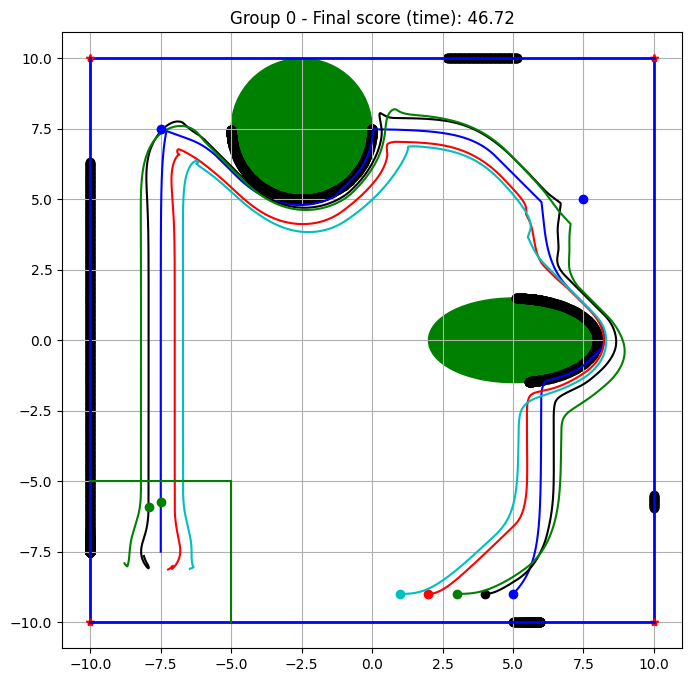

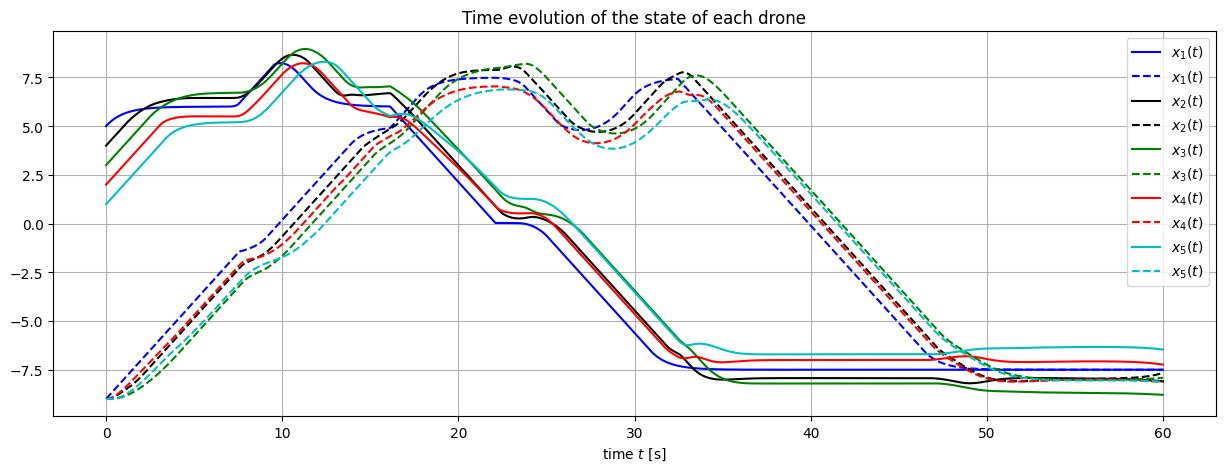

In [30]:
# Plot commands
%matplotlib inline
#%matplotlib notebook

import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(18,18))
fig, ax = plt.subplots(figsize=(8, 8))

# plt.figure(figsize=(1,1))
ax.axis('equal')
xdim, ydim = 10, 10
plt.xlim(-xdim - 1, xdim + 1)
plt.ylim(-ydim - 1, ydim + 1)
plt.grid()

# Plots walls and obstacles
sim.world.plot()

pt1, = plt.plot([], [], 'b.', ms=20)
pt2, = plt.plot([], [], 'k.', ms=20)
pt3, = plt.plot([], [], 'g.', ms=20)
pt4, = plt.plot([], [], 'r.', ms=20)
pt5, = plt.plot([], [], 'c.', ms=20)
plt.plot(sim.x_signal[0, 0, 0], sim.x_signal[0, 1, 0], marker='o', color='b')
plt.plot(sim.x_signal[1, 0, 0], sim.x_signal[1, 1, 0], marker='o', color='k')
plt.plot(sim.x_signal[2, 0, 0], sim.x_signal[2, 1, 0], marker='o', color='g')
plt.plot(sim.x_signal[3, 0, 0], sim.x_signal[3, 1, 0], marker='o', color='r')
plt.plot(sim.x_signal[4, 0, 0], sim.x_signal[4, 1, 0], marker='o', color='c')

line1, = plt.plot(sim.x_signal[0, 0, :], sim.x_signal[0, 1, :], label='$x_1(t)$', color='b')
points_lidar = plt.scatter(sim.cpx[0], sim.cpy[0], label='$cpx_1(t)$', marker='o', color='k')
line2, = plt.plot(sim.x_signal[1, 0, :], sim.x_signal[1, 1, :], label='$x_2(t)$', color='k')
line3, = plt.plot(sim.x_signal[2, 0, :], sim.x_signal[2, 1, :], label='$x_3(t)$', color='g')
line4, = plt.plot(sim.x_signal[3, 0, :], sim.x_signal[3, 1, :], label='$x_4(t)$', color='r')
line5, = plt.plot(sim.x_signal[4, 0, :], sim.x_signal[4, 1, :], label='$x_5(t)$', color='c')
plt.plot((-10, -5), (-5, -5), color='g')
plt.plot((-5, -5), (-5, -10), color='g')
plt.title('Group ' + str(Gnumber) + ' - Final score (time): ' + str(max(sim.time_score[2], sim.time_score[3])));

if sim.R_delivered[0] == False:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='r')
else:
    initial_resource1, = plt.plot(sim.initial_resource[0][0], sim.initial_resource[0][1], marker='o', color='b')
    final_resource1, = plt.plot(sim.resource[0][0], sim.resource[0][1], marker='o', color='g')

if sim.num_R == 2:
    if sim.R_delivered[1] == False:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='r')
    else:
        initial_resource2, = plt.plot(sim.initial_resource[1][0], sim.initial_resource[1][1], marker='o', color='b')
        final_resource2, = plt.plot(sim.resource[1][0], sim.resource[1][1], marker='o', color='g')

plt.figure(figsize=(15, 5))
plt.plot(sim.t_signal, sim.x_signal[0, 0, :], label='$x_1(t)$', color='b')
plt.plot(sim.t_signal, sim.x_signal[0, 1, :], label='$x_1(t)$', color='b', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[1, 0, :], label='$x_2(t)$', color='k')
plt.plot(sim.t_signal, sim.x_signal[1, 1, :], label='$x_2(t)$', color='k', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[2, 0, :], label='$x_3(t)$', color='g')
plt.plot(sim.t_signal, sim.x_signal[2, 1, :], label='$x_3(t)$', color='g', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[3, 0, :], label='$x_4(t)$', color='r')
plt.plot(sim.t_signal, sim.x_signal[3, 1, :], label='$x_4(t)$', color='r', linestyle='dashed')
plt.plot(sim.t_signal, sim.x_signal[4, 0, :], label='$x_5(t)$', color='c')
plt.plot(sim.t_signal, sim.x_signal[4, 1, :], label='$x_5(t)$', color='c', linestyle='dashed')
plt.xlabel('time $t$ [s]');
plt.legend(loc='best')
plt.grid()
plt.title('Time evolution of the state of each drone');


In [31]:
from matplotlib import animation

x1 = sim.x_signal[0, 0, :]
y1 = sim.x_signal[0, 1, :]
x2 = sim.x_signal[1, 0, :]
y2 = sim.x_signal[1, 1, :]
x3 = sim.x_signal[2, 0, :]
y3 = sim.x_signal[2, 1, :]
x4 = sim.x_signal[3, 0, :]
y4 = sim.x_signal[3, 1, :]
x5 = sim.x_signal[4, 0, :]
y5 = sim.x_signal[4, 1, :]


fnum = len(x1)



def drawframe(n):
    size_x = len(x1)
    frames = 100
    t_win = int(size_x / frames * (n + 1) - 1)
    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[0]:
            initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
            initial_resource1.set_color('r')
        else:
            initial_resource1.set_color('b')
    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[1]:
            initial_resource2.set_data(sim.initial_resource[1][0], sim.initial_resource[1][1])
            initial_resource2.set_color('r')
        else:
            initial_resource2.set_color('b')

    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[2]:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("w")
            final_resource1.set_alpha(0.0)
        else:
            final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
            final_resource1.set_color("g")
            final_resource1.set_alpha(1.0)

    if sim.time_score[2] != 999.9:
        if sim.t_signal[t_win] < sim.time_score[3]:
            final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
            final_resource2.set_color("w")
            final_resource2.set_alpha(0.0)
        else:
            final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
            final_resource2.set_color("g")
            final_resource2.set_alpha(1.0)

    pt1.set_data(sim.x_signal[0,0, t_win], sim.x_signal[0,1, t_win])
    pt2.set_data(sim.x_signal[1,0, t_win], sim.x_signal[1,1, t_win])
    pt3.set_data(sim.x_signal[2,0, t_win], sim.x_signal[2,1, t_win])
    pt4.set_data(sim.x_signal[3,0, t_win], sim.x_signal[3,1, t_win])
    pt5.set_data(sim.x_signal[4,0, t_win], sim.x_signal[4,1, t_win])

    line1.set_data(x1[0:t_win], y1[0:t_win])
    line2.set_data(x2[0:t_win], y2[0:t_win])
    line3.set_data(x3[0:t_win], y3[0:t_win])
    line4.set_data(x4[0:t_win], y4[0:t_win])
    line5.set_data(x5[0:t_win], y5[0:t_win])
    points_lidar.set_offsets(np.c_[sim.cpx[0][0:t_win], sim.cpy[0][0:t_win]])
    return (line1, line2)


# blit=True re-draws only the parts that have changed.
# anim = animation.FuncAnimation(fig, drawframe, frames=fnum, interval=1000, blit=True)
anim = animation.FuncAnimation(fig, drawframe, frames=100, interval=50, blit=True)

from IPython.display import HTML

HTML(anim.to_html5_video())

<ipython-input-31-ed0cfe183319>:25: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_resource1.set_data(sim.initial_resource[0][0], sim.initial_resource[0][1])
<ipython-input-31-ed0cfe183319>:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  initial_resource2.set_data(sim.initial_resource[1][0], sim.initial_resource[1][1])
<ipython-input-31-ed0cfe183319>:38: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  final_resource1.set_data(sim.resource[0][0], sim.resource[0][1])
<ipython-input-31-ed0cfe183319>:48: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  final_resource2.set_data(sim.resource[1][0], sim.resource[1][1])
<ipython